## Importacion de datos

In [5]:
!pip install tensorflow


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.reset_option("display.max_rows")
pd.set_option('display.max_columns', None)
filename = 'data_variables_objetivo.csv'

df = pd.read_csv(filename)
col = 'au_recuperacion'

In [105]:
df

,date_index,horas_operacion,toneladas,au_cabeza,ag_cabeza,pb_cabeza,zn_cabeza,fe_cabeza,cu_cabeza,au_concentrado_pb,ag_concentrado_pb,pb_concentrado_pb,zn_concentrado_pb,fe_concentrado_pb,cu_concentrado_pb,au_colas_pb,ag_colas_pb,pb_colas_pb,zn_colas_pb,fe_colas_pb,cu_colas_pb,au_concentrado_zn,ag_concentrado_zn,pb_concentrado_zn,zn_concentrado_zn,fe_concentrado_zn,cu_concentrado_zn,au_colas_zn,ag_colas_zn,pb_colas_zn,zn_colas_zn,fe_colas_zn,cu_colas_zn,au_concentrado_fe,ag_concentrado_fe,pb_concentrado_fe,zn_concentrado_fe,fe_concentrado_fe,cu_concentrado_fe,au_colas_fe,ag_colas_fe,pb_colas_fe,zn_colas_fe,fe_colas_fe,cu_colas_fe,au_recuperacion,ag_recuperacion,pb_recuperacion,zn_recuperacion,fe_recuperacion,au_contenido,ag_contenido,pb_contenido,zn_contenido,ag_concentrado_pb_ley,pb_concentrado_pb_ley,zn_concentrado_pb_ley,ag_concentrado_zn_ley,zn_concentrado_zn_ley,au_concentrado_fe_ley,ag_concentrado_fe_ley,fe_concentrado_fe_ley
0,2024-01-02_1,12.0,2042.20,0.991981,395.810002,0.806986,0.656214,5.784357,0.027701,23.439805,14143.800961,29.299741,10.118122,9.951662,0.713295,0.457145,68.253954,0.128125,0.430777,5.685068,0.011367,0.455007,65.414671,0.125637,0.298823,5.673291,0.010442,2.496992,640.014986,0.749494,3.604855,34.256666,0.067930,0.391205,47.461214,0.106145,0.195526,4.780200,0.008646,0.33,47.46,0.16,0.160,5.73,0.01,62.742370,88.671662,84.492474,79.873091,17.481809,1.271050,716.753600,13.924589,46.362309,14143.800961,29.299741,10.118122,1189.957338,52.561161,2.496992,640.014986,34.256666
1,2024-01-02_2,12.0,2042.20,1.088931,350.599999,0.779781,1.942134,5.381652,0.035221,31.055118,13517.780309,33.099183,8.520401,8.610519,0.666944,0.456001,72.489921,0.097148,1.803191,5.313453,0.021878,0.385025,38.749333,0.068131,0.143392,5.113240,0.009058,2.338633,639.049666,0.818290,3.051206,34.827484,0.070041,0.413376,47.460866,0.079018,0.185590,5.544452,0.009943,0.33,47.46,0.16,0.160,5.73,0.01,63.721450,87.063149,87.799272,83.971925,-8.975060,1.205204,530.177258,11.891555,28.326183,13517.780309,33.099183,8.520401,919.398482,43.465123,2.338633,639.049666,34.827484
2,2024-01-03_1,12.0,1955.00,1.294525,386.740000,1.170457,1.901957,6.033765,0.038873,29.936189,11565.332135,38.355623,9.486405,8.607234,0.649314,0.487999,71.960020,0.123353,1.688385,5.961299,0.021683,0.421861,44.211708,0.099727,0.168639,5.803291,0.009481,2.371649,639.476068,0.797413,3.139364,34.757763,0.070050,0.432495,47.458215,0.103533,0.184841,5.961206,0.009812,0.33,47.46,0.16,0.160,5.73,0.01,68.335607,88.369640,89.749758,77.982038,-2.977630,1.729435,668.142257,20.536926,28.996267,11565.332135,38.355623,9.486405,943.354408,49.413741,2.371649,639.476068,34.757763
3,2024-01-03_2,12.0,2068.40,1.320697,308.410002,1.032803,1.801547,5.784384,0.031786,37.388892,10725.032307,38.863268,10.561065,9.165881,0.762832,0.440757,54.280130,0.109869,1.587845,5.701887,0.013951,0.400794,33.320482,0.092689,0.128628,5.555102,0.010760,2.264858,639.625521,0.818287,2.900139,34.573644,0.071213,0.444263,47.459247,0.109609,0.193258,6.231802,0.008937,0.33,47.46,0.16,0.160,5.73,0.01,67.360786,85.068780,89.615372,79.272610,-13.524190,1.840114,542.666720,19.144081,29.539510,10725.032307,38.863268,10.561065,750.772639,50.077870,2.264858,639.625521,34.573644
4,2024-01-04_1,12.0,1857.10,1.378503,286.739996,1.032243,2.139257,5.631025,0.042235,37.887393,9050.180473,38.046329,10.878103,8.377537,0.808961,0.465431,67.569943,0.106535,1.920702,5.562335,0.023059,0.378647,33.900568,0.077828,0.141789,5.331825,0.008772,2.296030,639.566745,0.825265,2.837456,34.677839,0.069847,0.421571,47.459353,0.094561,0.202136,5.988782,0.010139,0.33,47.46,0.16,0.160,5.73,0.01,70.736983,84.162377,89.931045,81.392765,-13.191936,1.810879,448.168735,17.239580,32.335838,9050.180473,38.046329,10.878103,852.150337,43.373812,2.296030,639.566745,34.677839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_index             832 non-null    object 
 1   horas_operacion        832 non-null    float64
 2   toneladas              832 non-null    float64
 3   au_cabeza              832 non-null    float64
 4   ag_cabeza              832 non-null    float64
 5   pb_cabeza              832 non-null    float64
 6   zn_cabeza              832 non-null    float64
 7   fe_cabeza              832 non-null    float64
 8   cu_cabeza              832 non-null    float64
 9   au_concentrado_pb      832 non-null    float64
 10  ag_concentrado_pb      832 non-null    float64
 11  pb_concentrado_pb      832 non-null    float64
 12  zn_concentrado_pb      832 non-null    float64
 13  fe_concentrado_pb      832 non-null    float64
 14  cu_concentrado_pb      832 non-null    float64
 15  au_col

In [109]:
df.describe()

,horas_operacion,toneladas,au_cabeza,ag_cabeza,pb_cabeza,zn_cabeza,fe_cabeza,cu_cabeza,au_concentrado_pb,ag_concentrado_pb,pb_concentrado_pb,zn_concentrado_pb,fe_concentrado_pb,cu_concentrado_pb,au_colas_pb,ag_colas_pb,pb_colas_pb,zn_colas_pb,fe_colas_pb,cu_colas_pb,au_concentrado_zn,ag_concentrado_zn,pb_concentrado_zn,zn_concentrado_zn,fe_concentrado_zn,cu_concentrado_zn,au_colas_zn,ag_colas_zn,pb_colas_zn,zn_colas_zn,fe_colas_zn,cu_colas_zn,au_concentrado_fe,ag_concentrado_fe,pb_concentrado_fe,zn_concentrado_fe,fe_concentrado_fe,cu_concentrado_fe,au_colas_fe,ag_colas_fe,pb_colas_fe,zn_colas_fe,fe_colas_fe,cu_colas_fe,au_recuperacion,ag_recuperacion,pb_recuperacion,zn_recuperacion,fe_recuperacion,au_contenido,ag_contenido,pb_contenido,zn_contenido,ag_concentrado_pb_ley,pb_concentrado_pb_ley,zn_concentrado_pb_ley,ag_concentrado_zn_ley,zn_concentrado_zn_ley,au_concentrado_fe_ley,ag_concentrado_fe_ley,fe_concentrado_fe_ley
count,832.0,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,8.320000e+02,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000
mean,12.0,2045.604462,1.263661,492.728934,1.599283,2.901337,7.355301,0.047744,23.899875,11191.217624,41.468807,10.487379,8.122471,0.708864,0.493773,115.836465,0.228270,2.645398,7.333374,0.024970,0.445926,74.215536,0.172993,0.260350,7.154612,0.010776,2.367064,613.501096,0.723246,2.627922,34.951075,0.060023,0.346306,45.981782,0.145887,0.150829,5.702217,0.008416,0.338876,45.981947,0.161575,0.156088,5.720255,1.000000e-02,76.047837,91.443935,86.160379,79.439183,20.058465,1.957273,919.649982,27.936238,47.418125,11191.217624,41.468807,10.487379,857.988525,48.355446,2.367064,613.501096,34.951075
std,0.0,76.892943,0.249347,136.203572,0.411819,0.838970,0.963309,0.011343,5.606172,2179.315916,5.863075,2.050790,1.241460,0.205012,0.103162,35.378627,0.077251,0.829429,0.984434,0.006145,0.092777,21.365965,0.055770,0.100608,1.018153,0.000885,0.357949,142.368445,0.259054,1.223345,3.202669,0.016837,0.077900,11.334552,0.051203,0.056669,1.088999,0.000830,0.068046,11.335182,0.044864,0.053603,1.069113,1.596906e-16,5.775026,2.826820,4.318525,6.764634,13.354975,0.474221,278.037561,7.771596,15.877221,2179.315916,5.863075,2.050790,229.468445,5.265865,0.357949,142.368445,3.202669
min,12.0,1829.484575,0.574271,142.089998,0.487850,0.641128,4.790731,0.018812,10.469725,6147.698548,25.954200,5.389593,4.788938,0.170671,0.210737,50.747216,0.053074,0.393062,4.710141,0.010870,0.214618,33.320482,0.037677,0.049711,4.411151,0.008376,1.511991,228.488880,0.132359,0.323049,27.357693,0.017765,0.134230,19.239886,0.022680,0.006710,2.871967,0.006351,0.170000,19.240000,0.050000,0.010000,3.150000,1.000000e-02,60.144977,83.220968,73.782390,57.971659,-15.372139,0.641089,236.675607,6.145772,3.944207,6147.698548,25.954200,5.389593,369.033970,31.272086,1.511991,228.488880,27.357693
25%,12.0,2009.531688,1.086882,387.402500,1.296385,2.360639,6.722285,0.039328,20.056952,9631.397755,37.653607,9.210501,7.243897,0.567514,0.420771,88.822395,0.167685,2.108508,6.686365,0.022037,0.386036,58.657758,0.131436,0.177460,6.454168,0.010242,2.182179,514.182842,0.531867,1.692539,33.366196,0.048059,0.290709,38.600032,0.108640,0.105911,5.013814,0.007911,0.300000,38.600000,0.135000,0.110000,5.110000,1.000000e-02,72.251303,89.668017,83.581245,75.835343,11.209388,1.622721,708.753644,22.499273,37.100278,9631.397755,37.653607,9.210501,691.952505,45.646631,2.182179,514.182842,33.366196
50%,12.0,2042.200000,1.256049,485.910000,1.5

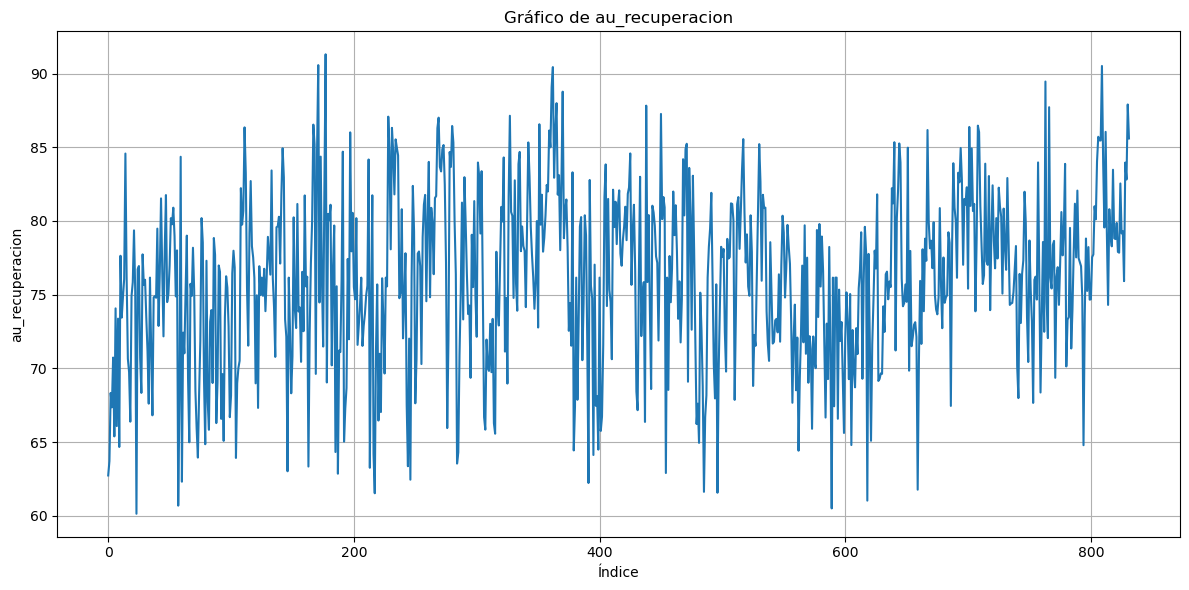

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt


# Graficamos la columna
df[col].plot(figsize=(12, 6), title=f"Gráfico de {col}")
plt.xlabel("Índice")
plt.ylabel(col)
plt.grid(True)
plt.tight_layout()
plt.show()

In [113]:
df_y = df[[col]]
df_y

,au_recuperacion
0,62.742370
1,63.721450
2,68.335607
3,67.360786
4,70.736983
...,...
827,75.920493
828,83.961391
829,82.811343
830,87.899513


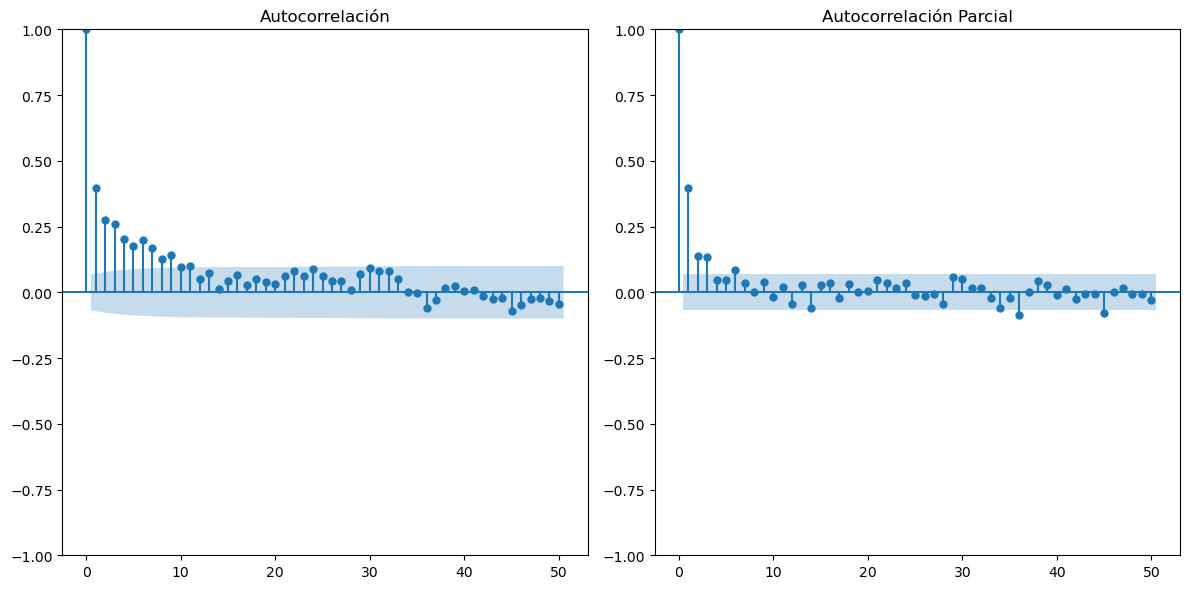

In [115]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar ACF y PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df_y[col], lags=50, ax=plt.gca(), title="Autocorrelación")
plt.subplot(122)
plot_pacf(df_y[col], lags=50, ax=plt.gca(), title="Autocorrelación Parcial")
plt.tight_layout() 
plt.show()

In [117]:
# Creamos características con rezagos
n_lags = 9
def create_lags(df, col=col, n_lags=9):
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df[col].shift(i)
    return df

In [119]:
df_lags= create_lags(df_y, col, n_lags)
df_lags = df_lags.dropna().reset_index(drop=True)

C:\Users\Cris2\AppData\Local\Temp\ipykernel_17664\2532461119.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{i}'] = df[col].shift(i)
C:\Users\Cris2\AppData\Local\Temp\ipykernel_17664\2532461119.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{i}'] = df[col].shift(i)
C:\Users\Cris2\AppData\Local\Temp\ipykernel_17664\2532461119.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [121]:
# 1. Obtener la primera columna
primera_columna = df_lags.iloc[:, 0]

# 2. Eliminar la primera columna del DataFrame original
df_lags = df_lags.iloc[:, 1:]

df_lags[col] = primera_columna
df_lags

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,au_recuperacion
0,73.376578,66.090970,74.071448,65.392053,70.736983,67.360786,68.335607,63.721450,62.742370,64.673544
1,64.673544,73.376578,66.090970,74.071448,65.392053,70.736983,67.360786,68.335607,63.721450,77.640732
2,77.640732,64.673544,73.376578,66.090970,74.071448,65.392053,70.736983,67.360786,68.335607,73.446119
3,73.446119,77.640732,64.673544,73.376578,66.090970,74.071448,65.392053,70.736983,67.360786,74.824362
4,74.824362,73.446119,77.640732,64.673544,73.376578,66.090970,74.071448,65.392053,70.736983,76.064226
...,...,...,...,...,...,...,...,...,...,...
818,79.307934,79.153353,82.542757,77.849807,77.903909,79.872392,78.773566,78.824656,83.473187,75.920493
819,75.920493,79.307934,79.153353,82.542757,77.849807,77.903909,79.872392,78.773566,78.824656,83.961391
820,83.961391,75.920493,79.307934,79.153353,82.542757,77.849807,77.903909,79.872392,78.773566,82.811343
821,82.811343,83.961391,75.920493,79.307934,79.153353,82.542757,77.849807,77.903909,79.872392,87.899513


In [123]:
def train_val_test_split(df, tr_size=0.8, vl_size=0.1, ts_size=0.1):
    #Definimos el numero de datos en cada subserie
    N = df.shape[0]
    Ntrain = int(tr_size*N)
    Nval = int(vl_size*N)
    Ntst = N - Ntrain - Nval

    # Realizar particion
    train = df[0:Ntrain]
    val = df[Ntrain:Ntrain+Nval]
    test = df[Ntrain+Nval:]

    return train, val, test

In [125]:
tr, vl, ts = train_val_test_split(df_lags)
print(f"tam set de entrenamiento: {tr.shape}")
print(f"tam set de validacion: {vl.shape}")
print(f"tam set de test: {ts.shape}")

tam set de entrenamiento: (658, 10)
tam set de validacion: (82, 10)
tam set de test: (83, 10)


In [143]:
import numpy as np

def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado 
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [145]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 14  # Hiperparámetro
OUTPUT_LENGTH = 4    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (640, 14, 10), y_tr: (640, 4, 1)
Set de validación - x_vl: (64, 14, 10), y_vl: (64, 4, 1)
Set de prueba - x_ts: (65, 14, 10), y_ts: (65, 4, 1)


In [147]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df_lags.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [149]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = col)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

x_tr_s.shape


(640, 14, 10)

IndexError: index 10 is out of bounds for axis 2 with size 10

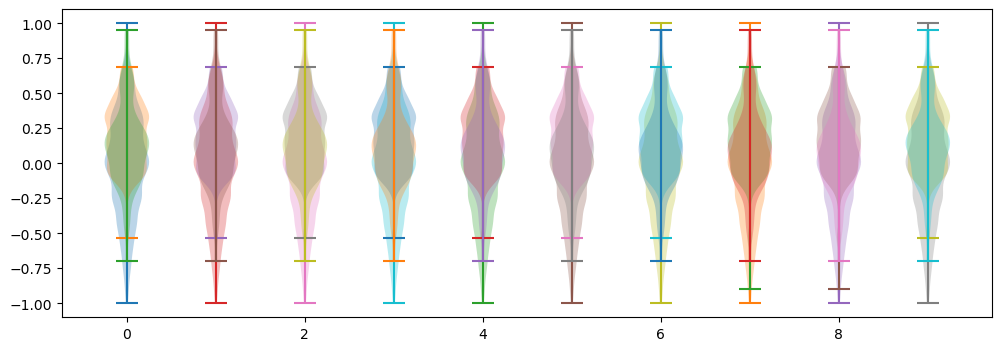

In [151]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(13):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(13)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

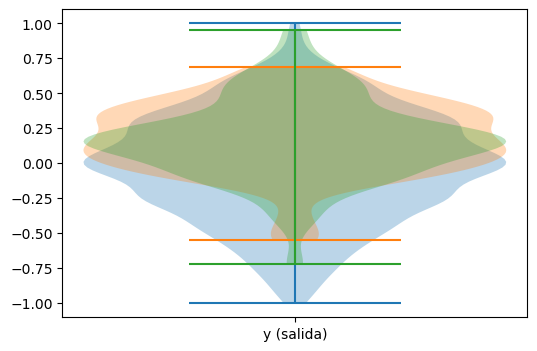

In [153]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

## Recomendaciones
1. Tomarlo por mineral
2. Entrenar solo para Recuperaciones y Leyes
3. Probar otros modelos que no sean de Deep Learning (por el tiempo y conocimiento)
4. Intentar Regresion Lineal y Logistica
5. Utilizar un Regresor Random Forest
6. Investigar el escalamiento por feature, investigar como hace el escalamiento el StandardScaler
7. Probar con los 0s en el ajuste
8. Quitar las columnas con valores faltantes y probar el ajuste
9. En vez de ser data augmentation el lag debe servir para el mantenimiento del modelo (lag de features)

## Entrenamiento del Modelo

## Opcion 1:

In [27]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

## Son demasiadas unidades REVISAR
# El modelo
N_UNITS = 32 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 5 dias x 45 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)
# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 200 # Hiperparámetro
BATCH_SIZE = 128 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/200


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 - 2s - 468ms/step - loss: 0.4300 - val_loss: 0.3158
Epoch 2/200
4/4 - 0s - 24ms/step - loss: 0.3789 - val_loss: 0.2885
Epoch 3/200
4/4 - 0s - 25ms/step - loss: 0.3484 - val_loss: 0.2689
Epoch 4/200
4/4 - 0s - 26ms/step - loss: 0.3265 - val_loss: 0.2538
Epoch 5/200
4/4 - 0s - 25ms/step - loss: 0.3106 - val_loss: 0.2419
Epoch 6/200
4/4 - 0s - 24ms/step - loss: 0.2994 - val_loss: 0.2325
Epoch 7/200
4/4 - 0s - 25ms/step - loss: 0.2917 - val_loss: 0.2252
Epoch 8/200
4/4 - 0s - 25ms/step - loss: 0.2864 - val_loss: 0.2194
Epoch 9/200
4/4 - 0s - 24ms/step - loss: 0.2826 - val_loss: 0.2150
Epoch 10/200
4/4 - 0s - 24ms/step - loss: 0.2797 - val_loss: 0.2114
Epoch 11/200
4/4 - 0s - 25ms/step - loss: 0.2773 - val_loss: 0.2086
Epoch 12/200
4/4 - 0s - 26ms/step - loss: 0.2754 - val_loss: 0.2061
Epoch 13/200
4/4 - 0s - 24ms/step - loss: 0.2736 - val_loss: 0.2039
Epoch 14/200
4/4 - 0s - 25ms/step - loss: 0.2720 - val_loss: 0.2019
Epoch 15/200
4/4 - 0s - 25ms/step - loss: 0.2706 - val_loss: 0.1999


## Opcion 2 

In [ ]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 5 dias x 45 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

# Jugar con esta funcion de activacion
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)
# Agregar mas capas y mas numero de neuronas


# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=0.01) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 128 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

## Opcion 3

In [155]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Configurar reproducibilidad
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# Hiperparámetros ajustados para pocos datos
N_UNITS = 8 # Reducir capacidad para evitar overfitting
DROPOUT_RATE = 0.3  # Regularización
LEARNING_RATE = 0.001  # Tasa de aprendizaje más baja
BATCH_SIZE = 4  # Batch pequeño para mejor generalización
EPOCHS = 200
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])  # (time_steps, n_features)

# Arquitectura
modelo = Sequential([
    # Capa LSTM con regularización
    LSTM(
        N_UNITS, 
        input_shape=INPUT_SHAPE,
        kernel_regularizer=tf.keras.regularizers.l2(1e-4),
        return_sequences=False  # Solo última salida
    ),
    LayerNormalization(),  # Estabiliza entrenamiento
    Dropout(DROPOUT_RATE),
    
    # Capa de salida
    Dense(OUTPUT_LENGTH, activation='linear')
])

# Función de pérdida
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Optimizador con decaimiento de tasa de aprendizaje
optimizador = Adam(
    learning_rate=LEARNING_RATE, 
    beta_1=0.9, 
    beta_2=0.999, 
    decay=1e-6
)

# Early Stopping para evitar overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Compilación
modelo.compile(
    optimizer=optimizador,
    loss=root_mean_squared_error
)

# Entrenamiento con aumento de datos en tiempo real
historia = modelo.fit(
    x=x_tr_s,
    y=y_tr_s,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_vl_s, y_vl_s),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
D:\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1766 - val_loss: 0.4282
Epoch 2/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6306 - val_loss: 0.3174
Epoch 3/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5052 - val_loss: 0.2985
Epoch 4/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4349 - val_loss: 0.2902
Epoch 5/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4145 - val_loss: 0.2780
Epoch 6/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4003 - val_loss: 0.2784
Epoch 7/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3862 - val_loss: 0.2797
Epoch 8/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3830 - val_loss: 0.2774
Epoch 9/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3805 - val_loss: 0.2770
Epoch 10/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3765 - val_loss: 0.2796
Epoch 11/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3733 - val_loss: 0.2779
Epoch 12/200
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

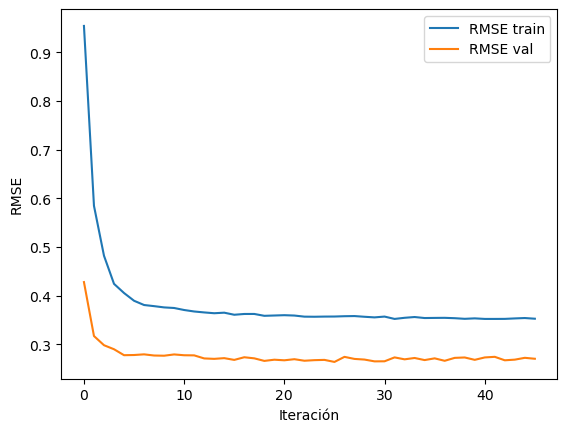

In [157]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

## Evaluacion del modelo

In [160]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.356
  RMSE val:	 0.269
  RMSE test:	 0.299


Forma de y_ts_s: (65, 4, 1)
Forma de y_ts_pred_s: (65, 4)


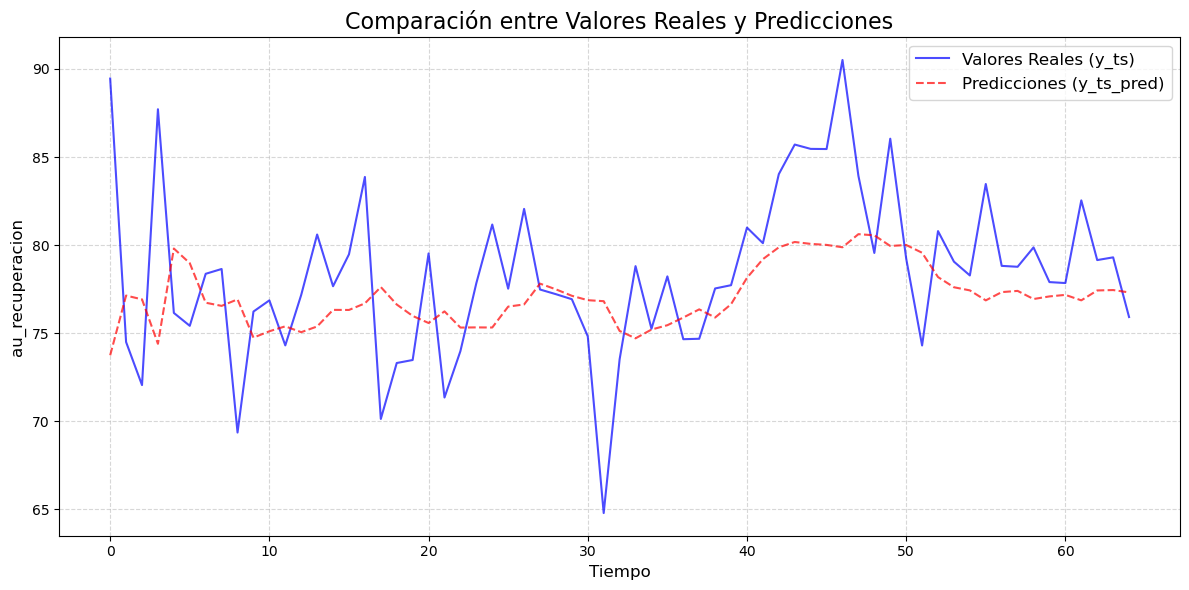

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generar las predicciones sobre el set de prueba
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

# 2. Verificar las formas de los arrays
print(f"Forma de y_ts_s: {y_ts_s.shape}")
print(f"Forma de y_ts_pred_s: {y_ts_pred_s.shape}")

# 3. Ajustar las formas si es necesario
if len(y_ts_s.shape) == 3:
    y_ts_s = np.squeeze(y_ts_s, axis=-1)
if len(y_ts_pred_s.shape) == 3:
    y_ts_pred_s = np.squeeze(y_ts_pred_s, axis=-1)

# 4. Realizar la transformación inversa de las predicciones
y_ts_original = scaler.inverse_transform(y_ts_s)
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 5. Graficar los datos de prueba y las predicciones
plt.figure(figsize=(12, 6))

# Graficar los datos de prueba (valores reales)
plt.plot(y_ts_original[:, 0], label='Valores Reales (y_ts)', color='blue', alpha=0.7)

# Graficar las predicciones del modelo
plt.plot(y_ts_pred[:, 0], label='Predicciones (y_ts_pred)', color='red', linestyle='--', alpha=0.7)

# Personalizar la gráfica
plt.title('Comparación entre Valores Reales y Predicciones', fontsize=16)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('au_recuperacion', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

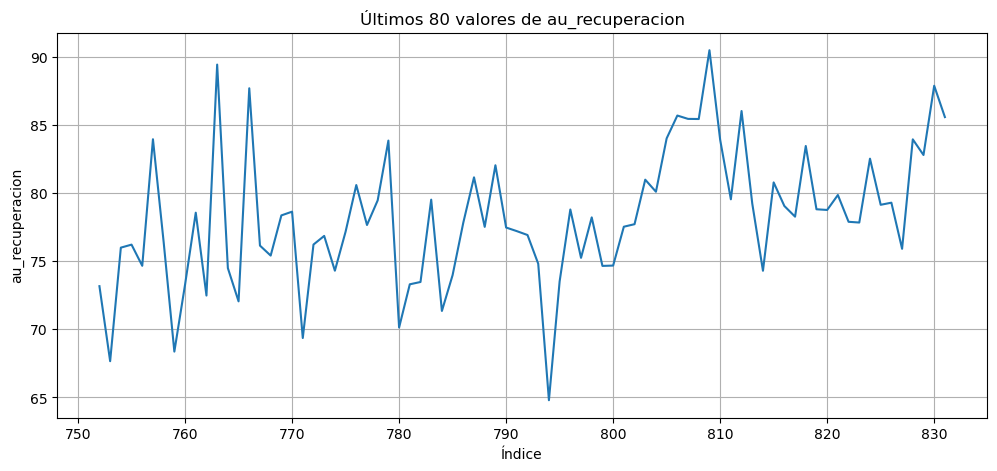

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reemplaza "zn_recuperacion" si deseas otra columna

# Graficar los últimos 80 valores
df[col].tail(80).plot(figsize=(12, 5), title=f"Últimos 80 valores de {col}")
plt.xlabel("Índice")
plt.ylabel(col)
plt.grid(True)
plt.show()


In [166]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_ts_s.reshape(-1, 1), y_ts_pred_s.reshape(-1, 1))
print(f'MSE: {mse}')

MSE: 0.08919201026639262


In [168]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_ts_s.reshape(-1, 1), y_ts_pred_s.reshape(-1, 1))
print(f'MAE: {mae}')

MAE: 0.22870767232890407


In [170]:
from sklearn.metrics import r2_score

r2 = r2_score(y_ts_s.reshape(-1, 1), y_ts_pred_s.reshape(-1, 1))
print(f'R²: {r2}')

R²: -0.02256500493080793


In [172]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_ts_s.reshape(-1, 1), y_ts_pred_s.reshape(-1, 1))
print(f'MAPE: {mape}%')

MAPE: 189.76985467756023%
